In [79]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [80]:
from torch.utils.data import random_split

batch_size = 128
random_seed = 42
torch.manual_seed(random_seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091),
                         (0.24703223, 0.24348513, 0.26158784))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

val_per = 0.2
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Train set:      ", len(train_set))
print("Validation set: ", len(val_set))
print("Test set:       ", len(test_set))

Files already downloaded and verified
Files already downloaded and verified
Train set:       40000
Validation set:  10000
Test set:        10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892129..2.1267893].


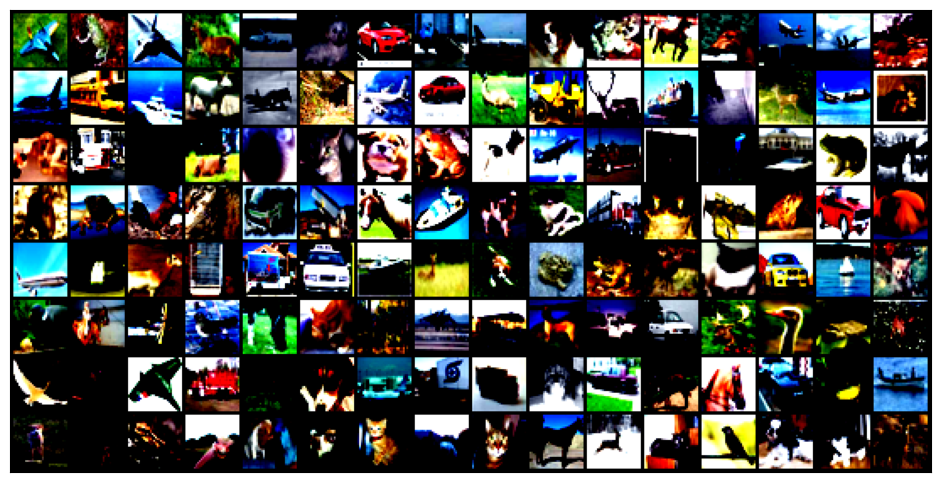

In [81]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [84]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()

In [85]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()

    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation loop"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = loss_fn(outputs, labels)
            acc = accuracy(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            running_accuracy += acc.item()

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_accuracy /len(val_loader)

    return {'val_loss': val_loss, 'val_acc': val_acc}

evaluate(model, val_loader)

Validation loop: 100%|██████████| 79/79 [00:00<00:00, 83.25it/s] 


{'val_loss': 2.3032734439849856, 'val_acc': 0.09632120253164557}

In [86]:
num_epochs = 5
lr = 0.01
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.Adafactor(model.parameters(), lr=lr)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
# optimizer = torch.optim.NAdam(model.parameters(), lr=lr)

def train(epochs, train_loader, val_loader, optimizer):
    history = []
    batch_losses = []

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        running_loss = 0.0
        
        for images, labels in tqdm(train_loader, desc="Training loop", disable=True):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            batch_losses.append(loss.item() * labels.size(0))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()

        running_loss = 0.0
        running_accuracy = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation loop", disable=True):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = loss_fn(outputs, labels)
                acc = accuracy(outputs, labels)

                running_loss += loss.item() * labels.size(0)
                running_accuracy += acc.item() * labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_accuracy /len(val_loader.dataset)
        
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, train_loss, val_loss, val_acc))

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    return history, batch_losses

history, batch_losses = train(num_epochs, train_loader, val_loader, optimizer)

Epoch [1], train_loss: 1.8041, val_loss: 4.4804, val_acc: 0.4473
Epoch [2], train_loss: 1.3244, val_loss: 1.3137, val_acc: 0.5737
Epoch [3], train_loss: 1.0793, val_loss: 1.9995, val_acc: 0.3999
Epoch [4], train_loss: 1.0104, val_loss: 0.9328, val_acc: 0.6814
Epoch [5], train_loss: 0.8010, val_loss: 0.8556, val_acc: 0.7089


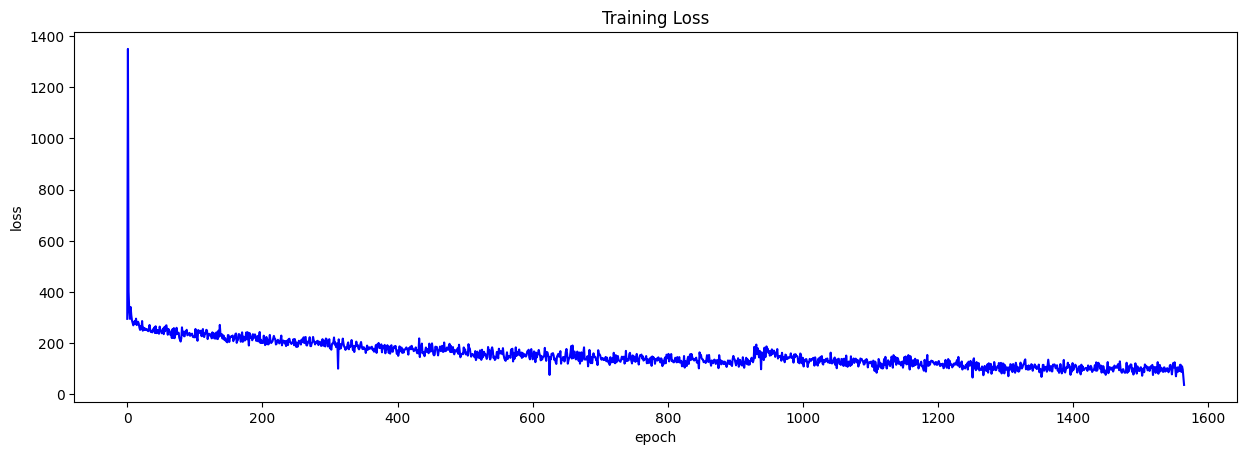

In [ ]:
def plot_batch_losses(batch_losses, path=None):
    plt.figure().set_figwidth(15)
    plt.plot(batch_losses, '-b')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training Loss')
    plt.show()

    if type(path) == str:
        plt.savefig(path)

plot_batch_losses(batch_losses)

In [88]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def test(model, test_loader):
    model.eval()

    total_accuracy = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Test loop"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = loss_fn(outputs, labels)
            acc = accuracy(outputs, labels)

            total_accuracy += acc.item()

    total_accuracy = total_accuracy / len(test_loader)

    return total_accuracy

pred_accuracy = test(model, val_loader)
print(pred_accuracy)

Test loop: 100%|██████████| 79/79 [00:00<00:00, 109.06it/s]

0.7100474683544303
